In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np

Reading data

In [2]:
messages = pandas.read_csv('./data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

<h4>Examining Data we have</h4>

In [3]:
print messages.head()

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
print "Shape = " , messages.shape, "\n"
print "Class Distribution = \n", messages.label.value_counts()

Shape =  (5574, 2) 

Class Distribution = 
ham     4827
spam     747
Name: label, dtype: int64


<h4>Preprocessing starts<h4>

In [5]:
#adding a column of length
messages['length'] = messages['message'].map(lambda text: len(text))

Defining functions to split the sentence
 1. Split into tokens
 2. Split into lemmas which changes words into lemmas after splitting into tokens

In [6]:
from textblob import TextBlob

In [7]:
# 1. 
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [8]:
# 2.
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [9]:
X = messages.message
y = messages.label
print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.series.Series'> (5574,)
<class 'pandas.core.series.Series'> (5574,)


In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print X_train.shape
print y_train.shape

(4459,)
(4459,)


Vectorising our sentences by making a vocabulary of words using
1. split into lemmas as analyser
2. stop words = english (inbuilt)

In [11]:
#import
from sklearn.feature_extraction.text import CountVectorizer
#instantiate
bow_vectorizer = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')
print bow_vectorizer
#fit
bow_vectorizer.fit(X_train)
#transform
messages_bow = bow_vectorizer.transform(X_train)

CountVectorizer(analyzer=<function split_into_lemmas at 0xac4ecdf4>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)


In [12]:
print type(messages_bow)
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

<class 'scipy.sparse.csr.csr_matrix'>
sparse matrix shape: (4459, 7829)
number of non-zeros: 64217
sparsity: 0.18%


Using stop words has decremented our vocabulary by a 1000 words
from 8874 to 7793. Now changed to 7829. Will change obviously.

<br>
Now using <b>TF-IDF</b> to transform our bag of words matrix

In [13]:
#import
from sklearn.feature_extraction.text import TfidfTransformer
#instantiate
tfidf_transformer = TfidfTransformer()
#fit and transform
messages_tfidf_X_train = tfidf_transformer.fit_transform(messages_bow)

<h4> Training our model </h4>

<h6>1. Logistic Regression</h6>

In [14]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
%time params_logreg = logreg.fit(messages_tfidf_X_train, y_train)
print type(params_logreg)
print logreg.coef_.size

CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 93.2 ms
<class 'sklearn.linear_model.logistic.LogisticRegression'>
7829


<h6>2. Naive Bayes<h6>

In [15]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time params_nb = nb.fit(messages_tfidf_X_train, y_train)
print type(params_nb)
print nb.coef_.size

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 20.3 ms
<class 'sklearn.naive_bayes.MultinomialNB'>
7829


<h6>3. Support Vector Machine<h6>

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [17]:
%time svm_detector = grid_svm.fit(X_train, y_train) # find the best combination from param_svm
print svm_detector.grid_scores_

CPU times: user 5min 34s, sys: 848 ms, total: 5min 34s
Wall time: 5min 54s
[mean: 0.98340, std: 0.00164, params: {'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.98318, std: 0.00142, params: {'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.98318, std: 0.00142, params: {'classifier__kernel': 'linear', 'classifier__C': 100}, mean: 0.98318, std: 0.00142, params: {'classifier__kernel': 'linear', 'classifier__C': 1000}, mean: 0.86701, std: 0.00046, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86701, std: 0.00046, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.86701, std: 0.00046, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.86701, std: 0.00046, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.96950, std: 0.00372, params: {'classifier__gamma': 0.001, 'classifier__kernel'

Naive Bayes is faster than Logistic Regression (Compare Wall time)
SVM is the slowest

<h4>Testing the models<h4>

In [18]:
#converting X_test to suitable form for input
X_test_tfidf = tfidf_transformer.transform(bow_vectorizer.transform(X_test))

In [19]:
y_pred_logreg = logreg.predict(X_test_tfidf)

In [20]:
y_pred_nb = nb.predict(X_test_tfidf)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

TODO: Using second method (manual one) to transform testing set

In [25]:
#Logistic Regression Accuracy
print accuracy_score(y_test, y_pred_logreg)

0.97130044843


In [26]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_logreg)
print '(row=expected, col=predicted)'

confusion matrix
[[961   0]
 [ 32 122]]
(row=expected, col=predicted)


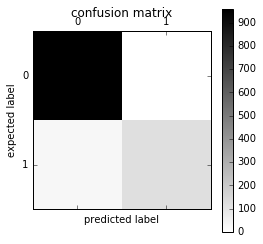

In [27]:
plt.matshow(confusion_matrix(y_test, y_pred_logreg), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [28]:
print classification_report(y_test, y_pred_logreg)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98       961
       spam       1.00      0.79      0.88       154

avg / total       0.97      0.97      0.97      1115



In [30]:
#Naive Bayes Accuracy
print accuracy_score(y_test, y_pred_nb)

0.956950672646


In [31]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb)
print '(row=expected, col=predicted)'

confusion matrix
[[961   0]
 [ 48 106]]
(row=expected, col=predicted)


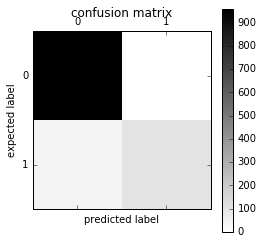

In [32]:
plt.matshow(confusion_matrix(y_test, y_pred_nb), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [33]:
print classification_report(y_test, y_pred_nb)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       961
       spam       1.00      0.69      0.82       154

avg / total       0.96      0.96      0.95      1115



<h6>Using Pipeline and GridSearchCV<h6>

In [34]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas, stop_words='english')),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [35]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [36]:
nb_detector = grid.fit(X_train, y_train)

In [37]:
print nb_detector.grid_scores_

[mean: 0.94752, std: 0.00405, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0xac4ecdf4>}, mean: 0.92868, std: 0.00302, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0xac4ecdf4>}, mean: 0.94528, std: 0.00491, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0xac4ecd4c>}, mean: 0.92891, std: 0.00395, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0xac4ecd4c>}]


In [38]:
y_pred_nb_grid = nb_detector.predict(X_test)

In [40]:
print accuracy_score(y_test, y_pred_nb_grid)

0.956950672646


In [41]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb_grid)
print '(row=expected, col=predicted)'

confusion matrix
[[961   0]
 [ 48 106]]
(row=expected, col=predicted)


In [42]:
print classification_report(y_test, y_pred_nb_grid)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98       961
       spam       1.00      0.69      0.82       154

avg / total       0.96      0.96      0.95      1115



Results improved!

In [43]:
print nb_detector.predict(["Hi mom, how are you?"])[0]

ham


In [45]:
#SVM Accuracy
y_pred_svm = svm_detector.predict(X_test)
print accuracy_score(y_test, y_pred_svm)
print confusion_matrix(y_test, y_pred_svm)
print classification_report(y_test, y_pred_svm)

0.992825112108
[[959   2]
 [  6 148]]
             precision    recall  f1-score   support

        ham       0.99      1.00      1.00       961
       spam       0.99      0.96      0.97       154

avg / total       0.99      0.99      0.99      1115



<h3>Comparing Models</h3>

LR: 0.962101 (0.008875)
NB: 0.950885 (0.009380)
SVM: 0.867010 (0.013900)


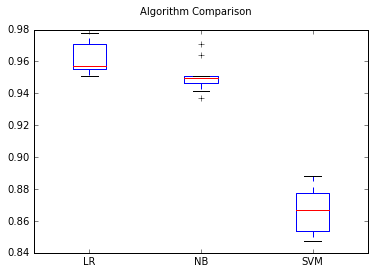

In [46]:
from sklearn import cross_validation
# prepare configuration for cross validation test harness
num_folds = 10
num_instances = len(X_train)
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, messages_tfidf_X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

This is some kind of plot, I have no idea what is happening. 